In [ ]:
import numpy as np

rng = np.random.default_rng(42)
n = 10000
d = 10000
sigma2_W_0 = 1.0

X = rng.standard_normal((n, d))
W_0 = rng.standard_normal((d, n)) * np.sqrt(sigma2_W_0 / d)
x_i = X[0]
h1 = x_i @ W_0
x1_sigma = np.maximum(0, h1)
h_vectors = [h1, x1_sigma]

sigma2_x1 = sigma2_W_0 * (1/2 - 1/(2*np.pi))
Sigma = np.array([[sigma2_W_0, 0.0], [0.0, sigma2_x1]])

def sample_Zs(n_samples, rng=None):
    rng = rng or np.random.default_rng()
    return rng.multivariate_normal(np.zeros(2), Sigma, size=n_samples)

In [7]:
def master_theorem_check(h_vectors, sample_Zs, psi_list, n_Z_samples=50_000):
    Z_samples = sample_Zs(n_Z_samples)
    k = Z_samples.shape[1]
    results = []
    for name, psi in psi_list:
        rhs = np.mean([psi(*Z_samples[i]) for i in range(n_Z_samples)])
        if h_vectors is not None and len(h_vectors) == k:
            n = len(h_vectors[0])
            lhs = (1 / n) * sum(psi(*(h_vectors[j][α] for j in range(k))) for α in range(n))
            results.append((name, lhs, rhs, np.isclose(lhs, rhs, atol=0.05)))
        else:
            results.append((name, None, rhs, None))
    return results

psi_list = [
    ("E[Z1^2]", lambda *zs: zs[0]**2),
    ("E[Z1+Z2]", lambda *zs: zs[0] + zs[1]),
    ("E[Z1*Z2]", lambda *zs: zs[0] * zs[1]),
]

out = master_theorem_check(h_vectors, sample_Zs, psi_list)
for name, lhs, rhs, ok in out:
    print(f"{name}:  LHS={lhs:.6f}  RHS={rhs:.6f}  ok={ok}")

E[Z1^2]:  LHS=1.041023  RHS=1.005605  ok=True
E[Z1+Z2]:  LHS=0.384809  RHS=-0.000332  ok=False
E[Z1*Z2]:  LHS=0.511893  RHS=-0.000435  ok=False


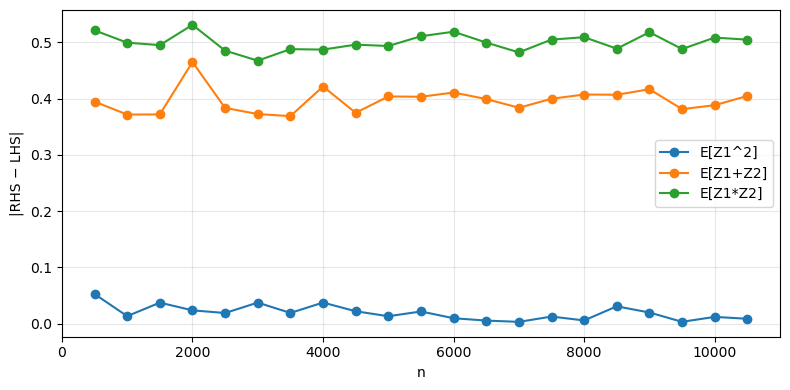

In [8]:
import matplotlib.pyplot as plt

sizes = np.arange(500, 11_000, 500)
rng_scan = np.random.default_rng(43)
errors_by_psi = {name: [] for name, _ in psi_list}

for n_val in sizes:
    X_n = rng_scan.standard_normal((n_val, n_val))
    W_0_n = rng_scan.standard_normal((n_val, n_val)) * np.sqrt(sigma2_W_0 / n_val)
    h1_n = X_n[0] @ W_0_n
    x1_sigma_n = np.maximum(0, h1_n)
    h_vectors_n = [h1_n, x1_sigma_n]
    out = master_theorem_check(h_vectors_n, sample_Zs, psi_list)
    for (name, _), (_, lhs, rhs, _) in zip(psi_list, out):
        if lhs is not None:
            errors_by_psi[name].append(np.abs(rhs - lhs))

fig, ax = plt.subplots(figsize=(8, 4))
for name in errors_by_psi:
    ax.plot(sizes, errors_by_psi[name], "o-", label=name)
ax.set_xlabel("n")
ax.set_ylabel("|RHS − LHS|")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()